In [1]:
import torch.nn  as nn
import numpy as np
import torchvision
from torchvision.datasets import MNIST
import torchvision.utils
import matplotlib.pyplot as plt
import random
from torchvision.transforms import transforms
from torch.utils.data import random_split
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
import torch

In [2]:
dataset = MNIST(root = "data/" , download = True , transform= transforms.ToTensor())

In [3]:
image,label = dataset[0]

In [4]:
image[0].shape

torch.Size([28, 28])

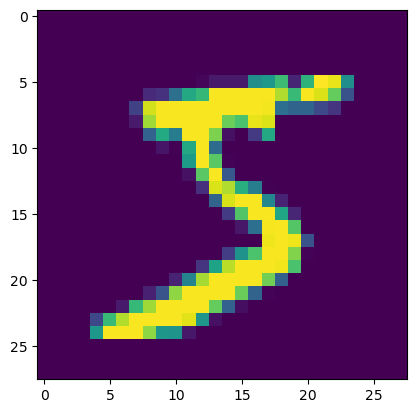

In [5]:
plt.imshow(image[0])

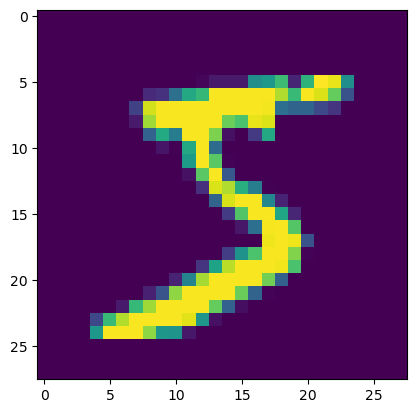

In [6]:
plt.imshow(image.permute(1,2,0))

In [7]:
validation_set_len = 10000
total_dataset_len = len(dataset)
train_dataset_len = total_dataset_len - validation_set_len
print(train_dataset_len)

50000


In [8]:
train_dataset , validation_dataset = random_split(dataset , [train_dataset_len,validation_set_len])

In [9]:
print(train_dataset, validation_dataset)

<torch.utils.data.dataset.Subset object at 0x000001F94FD4D820> <torch.utils.data.dataset.Subset object at 0x000001F94FCB3D70>


In [10]:
batch_size = 128

In [11]:
train_dataloader = DataLoader(dataset= train_dataset, batch_size = batch_size , shuffle= True , num_workers=4)
validation_dataloader = DataLoader(dataset= validation_dataset , batch_size= batch_size , shuffle= False , num_workers= 4)

torch.Size([3, 242, 482])
torch.Size([242, 482, 3])


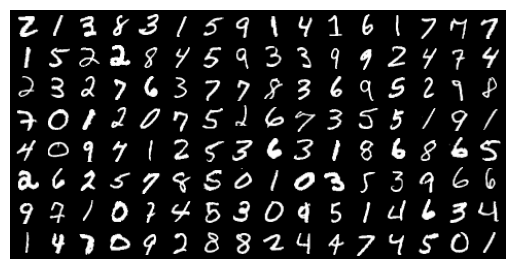

In [12]:
for images , labels in train_dataloader :
    grid = torchvision.utils.make_grid(images,nrow = 16)
    print(grid.shape)
    grid = grid.permute(1,2,0)
    print(grid.shape) 
    plt.axis('off')
    plt.imshow(grid)
    break

In [13]:
for images , labels in train_dataloader :
    inputs = images.reshape(-1,28*28*1)
    print(inputs.shape) #[-1,784]
    break
input_size = inputs.shape[-1]  #784
hidden_size = 32
     

torch.Size([128, 784])


In [14]:
layer1 = nn.Linear(input_size,hidden_size)

In [15]:
class MnistModel(nn.Module):
    def __init__(self , input_size , hidden_size , out_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)

    def forward(self , xb):
        xb = xb.reshape(xb.size(0),-1)
        #print(xb.shape)
        out = self.linear1(xb);
        out = F.relu(out)
        out = self.linear2(out);
        return out

    def training_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
        return loss

    def validation_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
       # print(output.shape)
       # print(labels)
        
        acc = self.accuracy(output , labels)
        return {'val_loss' : loss , "val_acc" : acc}
         
    def validation_epoch_end(self , output):
        batch_losses = [x['val_loss'] for x in output]
        batch_accuracy = [x['val_acc'] for x in output]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'epoch_val_loss' : epoch_loss.item() , 'epoch_val_accuracy' : epoch_accuracy.item()}

    def epoch_end(self , epoch , result):
        print('Epoch ' + str(epoch) +  ' Validation Loss : ' + str(result['epoch_val_loss']) + ' Validation Accuracy' + str(result['epoch_val_accuracy']) + "\n")

    def accuracy(self,outputs , label):
        probabilities,prediction = torch.max(outputs,dim=1)
        return torch.sum(label == prediction) / label.numel()   



In [16]:
model = MnistModel(input_size = 28*28 * 1, hidden_size= 32,out_size=10)

In [17]:
for param in model.parameters() :
    print(param.shape) ## because there are two layers , you will see two weight and  bais matrices

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [18]:
for batch in train_dataloader : 
    loss = model.training_step(batch)
    print('Loss' , loss.item())
    break
    

Loss 2.321714401245117


<h2>Using GPU</h2>

In [19]:
isCudaAvailable = torch.cuda.is_available()
print(isCudaAvailable)

True


In [20]:
def get_degault_device():
    device_name = ''
    if torch.cuda.is_available() :
        device_name = 'cuda'
    else: 
        device_name = 'cpu' 
        
    return torch.device(device_name)
        

In [21]:
print(get_degault_device())

cuda


In [22]:
def to_device(data,device):
    if isinstance(data,(list,tuple)) :
        return[to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

In [23]:
def to_default_device(data):
    return to_device(data,get_degault_device())

In [24]:
for images,labels in train_dataloader : 
    print(images.shape)
    print(images.device)
    images = to_default_device(images)
    print(images.shape)
    print(images.device)
    break
    

torch.Size([128, 1, 28, 28])
cpu
torch.Size([128, 1, 28, 28])
cuda:0


In [25]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for item in self.dl :
            yield to_device(item,self.device)
               

    def to_device(data,device):
        if isinstance(data,(list,tuple)) :
            return[to_device(x,device) for x in data]
        return data.to(device,non_blocking = True)

    def __len__(self):
        return len(self.dl)



In [26]:
train_dataloader = DeviceDataLoader(dl=train_dataloader,device=get_degault_device())
validation_dataloader = DeviceDataLoader(dl=validation_dataloader,device=get_degault_device())

In [27]:
for batch in train_dataloader:
    print(batch[0].device)
    print(batch[1])
    break

cuda:0
tensor([3, 0, 0, 1, 1, 7, 3, 0, 3, 5, 6, 9, 3, 3, 5, 4, 7, 4, 1, 7, 1, 1, 9, 2,
        1, 1, 9, 0, 2, 2, 0, 2, 1, 1, 0, 9, 9, 9, 2, 6, 1, 6, 1, 2, 3, 4, 7, 6,
        8, 4, 4, 3, 9, 5, 8, 3, 3, 1, 5, 9, 0, 9, 1, 8, 0, 4, 0, 3, 3, 5, 5, 2,
        5, 0, 1, 2, 6, 2, 9, 8, 3, 8, 0, 5, 0, 4, 5, 3, 1, 2, 9, 2, 0, 3, 8, 7,
        7, 5, 8, 8, 0, 7, 9, 2, 4, 9, 3, 0, 9, 5, 7, 9, 9, 2, 9, 5, 1, 2, 3, 1,
        1, 1, 4, 5, 3, 0, 6, 7], device='cuda:0')


In [28]:
def fit(epochs , lr , model , train_loader , val_loader , opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        
        epoch_val_result = []
        for val_batch in val_loader:
            val_result = model.validation_step(val_batch)
            epoch_val_result.append(val_result)
               
        epoch_end_val_result = model.validation_epoch_end(epoch_val_result)
        model.epoch_end(epoch,epoch_end_val_result)
        history.append(epoch_end_val_result)
        
    return history

In [40]:
model = to_default_device(model)
print(next(model.parameters()).is_cuda)

True


In [54]:
model.load_state_dict(torch.load("mnist-multilayer.pth"))

<All keys matched successfully>

In [55]:
history = fit(50, 0.001,model,train_loader=train_dataloader,val_loader= validation_dataloader)
torch.save(model.state_dict(),"mnist-multilayer.pth")

Epoch 0 Validation Loss : 0.3270755112171173 Validation Accuracy0.9069422483444214

Epoch 1 Validation Loss : 0.32650041580200195 Validation Accuracy0.9071400761604309

Epoch 2 Validation Loss : 0.3259085416793823 Validation Accuracy0.9075356125831604

Epoch 3 Validation Loss : 0.32538217306137085 Validation Accuracy0.9077333807945251

Epoch 4 Validation Loss : 0.3249496817588806 Validation Accuracy0.9081289768218994

Epoch 5 Validation Loss : 0.3243520259857178 Validation Accuracy0.9079312086105347

Epoch 6 Validation Loss : 0.32382309436798096 Validation Accuracy0.9084256291389465

Epoch 7 Validation Loss : 0.3233564496040344 Validation Accuracy0.9084256291389465

Epoch 8 Validation Loss : 0.32285434007644653 Validation Accuracy0.9084256291389465

Epoch 9 Validation Loss : 0.3223389685153961 Validation Accuracy0.9084256291389465

Epoch 10 Validation Loss : 0.32192063331604004 Validation Accuracy0.9092168211936951

Epoch 11 Validation Loss : 0.3214360475540161 Validation Accuracy0.908

{'epoch_val_loss': 0.5828487873077393, 'epoch_val_accuracy': 0.8569027185440063}
{'epoch_val_loss': 0.5700340867042542, 'epoch_val_accuracy': 0.8582872152328491}
{'epoch_val_loss': 0.5582197308540344, 'epoch_val_accuracy': 0.860561728477478}
{'epoch_val_loss': 0.5473482012748718, 'epoch_val_accuracy': 0.8627373576164246}
{'epoch_val_loss': 0.5372887253761292, 'epoch_val_accuracy': 0.8645174503326416}
{'epoch_val_loss': 0.527904212474823, 'epoch_val_accuracy': 0.8657041192054749}
{'epoch_val_loss': 0.519102931022644, 'epoch_val_accuracy': 0.8673853278160095}
{'epoch_val_loss': 0.5109508633613586, 'epoch_val_accuracy': 0.8681764602661133}
{'epoch_val_loss': 0.5033446550369263, 'epoch_val_accuracy': 0.8698576092720032}
{'epoch_val_loss': 0.4961996078491211, 'epoch_val_accuracy': 0.8703520894050598}
{'epoch_val_loss': 0.48947662115097046, 'epoch_val_accuracy': 0.8720332384109497}
{'epoch_val_loss': 0.4833005368709564, 'epoch_val_accuracy': 0.8729232549667358}
{'epoch_val_loss': 0.477279394

Text(0, 0.5, 'accuracy')

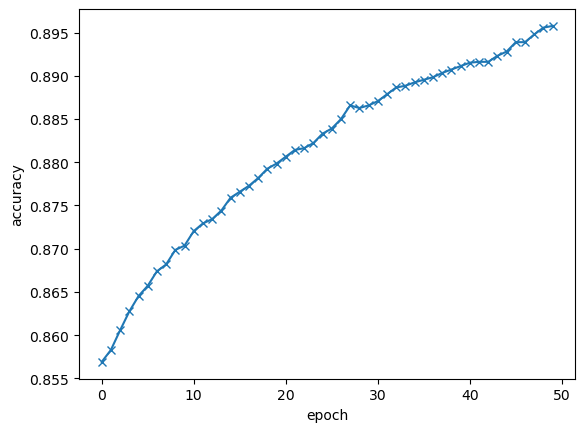

In [42]:
for each_epoch_result in history:
    print(each_epoch_result)
accuracies = [each_epoch_result['epoch_val_accuracy']for each_epoch_result in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')


In [43]:
test_dataset = MNIST(root = 'data/',train=False , transform= transforms.ToTensor())

In [46]:
def predict_image(img , model):
    img = to_default_device(img)
    image_with_batch_dimention = img.unsqueeze(0) #adds another dimention as the model as the batch size as the first dimention.
    result = model(image_with_batch_dimention)
    max_value , index = torch.max(result,dim = 1)
    return index.item()
    

Label is 6 Prediction is 0


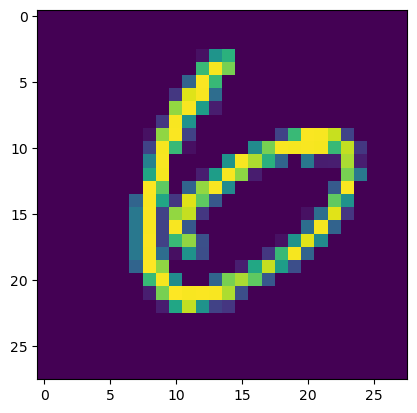

In [49]:
img,label=test_dataset[random.randint(0,len(test_dataset))]
predict_image(img,model)
print("Label is " + str(label) + " Prediction is " + str(predict_image(img,model)))
plt.imshow(img[0])